In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

In [2]:
# Step 2: Load Dataset
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = ImageFolder(root='/Users/Nicolas/Desktop/MAESTRIA/Summer/Intro ML/Takehome_Scott/STA380-master/data/EuroSAT_RGB', transform=data_transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

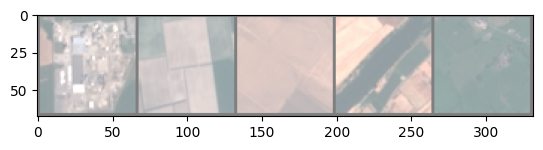

Labels: Industrial AnnualCrop AnnualCrop River Pasture


In [3]:
# Function to display a sample of images
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training images and display them
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:5]))

#Real Labels
classes = dataset.classes
label_nm = [classes[labels[j]] for j in range(5)]
print('Labels:', ' '.join(label_nm))

## First Net

### Set up network

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)  # in_channels, out_channels, kernel_size, stride
        self.conv2 = nn.Conv2d(32, 64, 3, 1) # in_channels, out_channels, kernel_size, stride
        self.conv3 = nn.Conv2d(64, 128, 3, 1) # in_channels, out_channels, kernel_size, stride
        self.conv4 = nn.Conv2d(128, 256, 3, 1) # in_channels, out_channels, kernel_size, stride 
        self.fc1 = nn.Linear(28*28*256, 128) # in_features, out_features
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [5]:
# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

### Train Model

In [6]:
# Number of training epochs
num_epochs = 5

testiter = iter(testloader)
# Main training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    # Print average loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)}")


print('Finished Training')

Epoch 1, Loss: 1.3283480671600059
Epoch 2, Loss: 0.7718764566492151
Epoch 3, Loss: 0.5602761228437777
Epoch 4, Loss: 0.42893488345322783
Epoch 5, Loss: 0.3221832792240161
Finished Training


In [44]:
# create a function that will display images with their labels and predictions
def imshow_with_label(img, label, pred, title):
    plt.figure(figsize=(10, 10))
    for i in range(len(img)):
        plt.subplot(5, 5, i+1)
        image = img[i] / 2 + 0.5
        npimg = image.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title('label: {}, \npred: {}'.format(label[i], pred[i]), fontsize=8)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

### Accuracy of the model

In [8]:
#Create function that will get accuracy of the model
def get_accuracy(model, testloader, classes):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


accuracy = get_accuracy(net, testloader, dataset.classes)
print('Accuracy of the network on the test images: %d %%' % accuracy)

Accuracy of the network on the test images: 80 %


### Predictions

In [9]:
# Function to get predictions for the entire dataset
def get_predictions(model, testloader, classes):
    all_images = []
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_images.append(images.cpu())
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    all_images = torch.cat(all_images)
    
    # Get the real names of the labels and predictions
    label_nm = [classes[label] for label in all_labels]
    pred_nm = [classes[pred] for pred in all_preds]
    
    return all_images, label_nm, pred_nm

# Get predictions and display them
all_images, all_labels, all_preds = get_predictions(net, testloader, dataset.classes)

Correct Predictions:


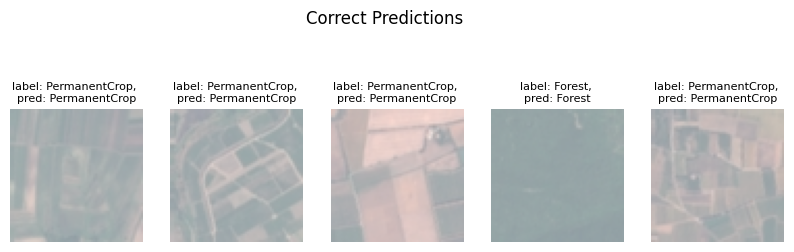


Incorrect Predictions:


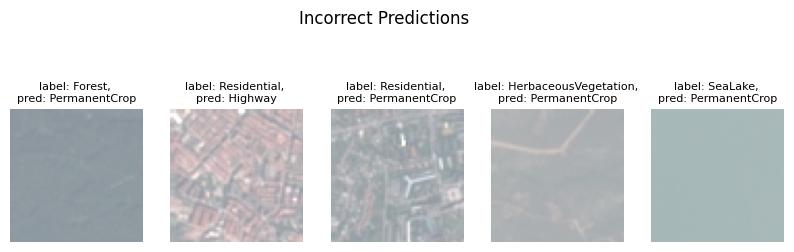

In [45]:
# Display 5 correct and 5 incorrect predictions
def display_correct_and_incorrect(all_images, all_labels, all_preds, classes):
    correct_indices = [i for i in range(len(all_labels)) if all_labels[i] == all_preds[i]]
    incorrect_indices = [i for i in range(len(all_labels)) if all_labels[i] != all_preds[i]]

    # Select 5 correct and 5 incorrect predictions (or fewer if not enough)
    correct_images = [all_images[i] for i in correct_indices[:5]]
    correct_labels = [all_labels[i] for i in correct_indices[:5]]
    correct_preds = [all_preds[i] for i in correct_indices[:5]]

    incorrect_images = [all_images[i] for i in incorrect_indices[:5]]
    incorrect_labels = [all_labels[i] for i in incorrect_indices[:5]]
    incorrect_preds = [all_preds[i] for i in incorrect_indices[:5]]

    print("Correct Predictions:")
    imshow_with_label(correct_images, correct_labels, correct_preds, 'Correct Predictions')

    print("\nIncorrect Predictions:")
    imshow_with_label(incorrect_images, incorrect_labels, incorrect_preds, 'Incorrect Predictions')

# Display the selected images
display_correct_and_incorrect(all_images, all_labels, all_preds, dataset.classes)

### Confusion Matrix

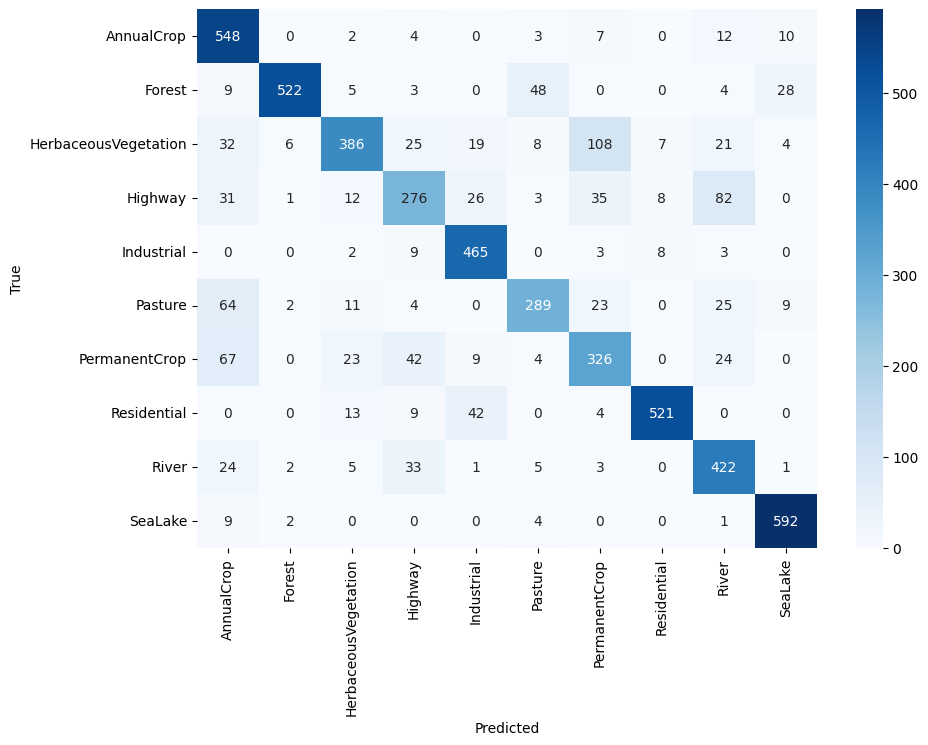

In [12]:
import pandas as pd
# Create confusion matrix with all classes
cm = confusion_matrix(all_labels, all_preds, labels=dataset.classes)

# Convert to DataFrame for better visualization
df_cm = pd.DataFrame(cm, index=dataset.classes, columns=dataset.classes)

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Notice how the model is confusing Permanent Crops with herbaceous vegetation and slightly less but still, highways with rivers.

## Second Net

In [13]:
# Use the same model defined before, but train with more epochs
# Number of training epochs
num_epochs = 10

testiter = iter(testloader)
# Main training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    # Print average loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)}")


print('Finished Training')

Epoch 1, Loss: 0.22578406852980454
Epoch 2, Loss: 0.15703668774554022
Epoch 3, Loss: 0.13299688724111075
Epoch 4, Loss: 0.09625098335780893
Epoch 5, Loss: 0.07380175702842988
Epoch 6, Loss: 0.08300373767226658
Epoch 7, Loss: 0.07369325005587328
Epoch 8, Loss: 0.0378542177873627
Epoch 9, Loss: 0.05436757585007904
Epoch 10, Loss: 0.05056728146321365
Finished Training


Ran 10 epochs to reduce Loss as much as possible without overfitting

### Accuracy

In [14]:
#Create function that will get accuracy of the model
def get_accuracy(model, testloader, classes):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


accuracy = get_accuracy(net, testloader, dataset.classes)
print('Accuracy of the network on the test images: %d %%' % accuracy)

Accuracy of the network on the test images: 80 %


Surprisingly, accuracy decreased with more epochs

In [15]:
# Function to get predictions for the entire dataset
def get_predictions(model, testloader, classes):
    all_images = []
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_images.append(images.cpu())
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    all_images = torch.cat(all_images)
    
    # Get the real names of the labels and predictions
    label_nm = [classes[label] for label in all_labels]
    pred_nm = [classes[pred] for pred in all_preds]
    
    return all_images, label_nm, pred_nm

# Get predictions and display them
all_images, all_labels, all_preds = get_predictions(net, testloader, dataset.classes)

Correct Predictions:


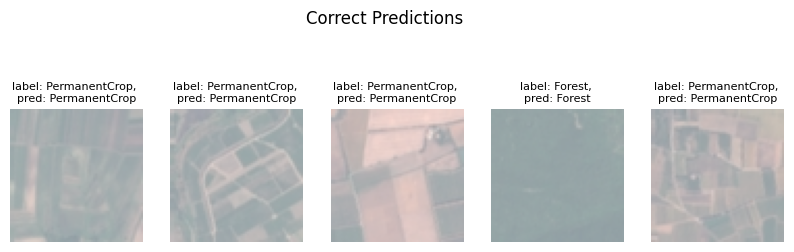


Incorrect Predictions:


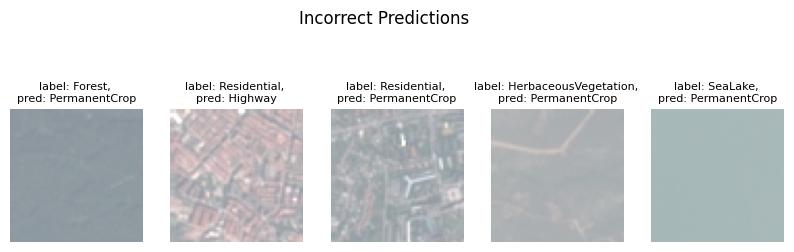

In [46]:
# Display 5 correct and 5 incorrect predictions
def display_correct_and_incorrect(all_images, all_labels, all_preds, classes):
    correct_indices = [i for i in range(len(all_labels)) if all_labels[i] == all_preds[i]]
    incorrect_indices = [i for i in range(len(all_labels)) if all_labels[i] != all_preds[i]]

    # Select 5 correct and 5 incorrect predictions (or fewer if not enough)
    correct_images = [all_images[i] for i in correct_indices[:5]]
    correct_labels = [all_labels[i] for i in correct_indices[:5]]
    correct_preds = [all_preds[i] for i in correct_indices[:5]]

    incorrect_images = [all_images[i] for i in incorrect_indices[:5]]
    incorrect_labels = [all_labels[i] for i in incorrect_indices[:5]]
    incorrect_preds = [all_preds[i] for i in incorrect_indices[:5]]

    print("Correct Predictions:")
    imshow_with_label(correct_images, correct_labels, correct_preds, 'Correct Predictions')

    print("\nIncorrect Predictions:")
    imshow_with_label(incorrect_images, incorrect_labels, incorrect_preds, 'Incorrect Predictions')

# Display the selected images
display_correct_and_incorrect(all_images, all_labels, all_preds, dataset.classes)

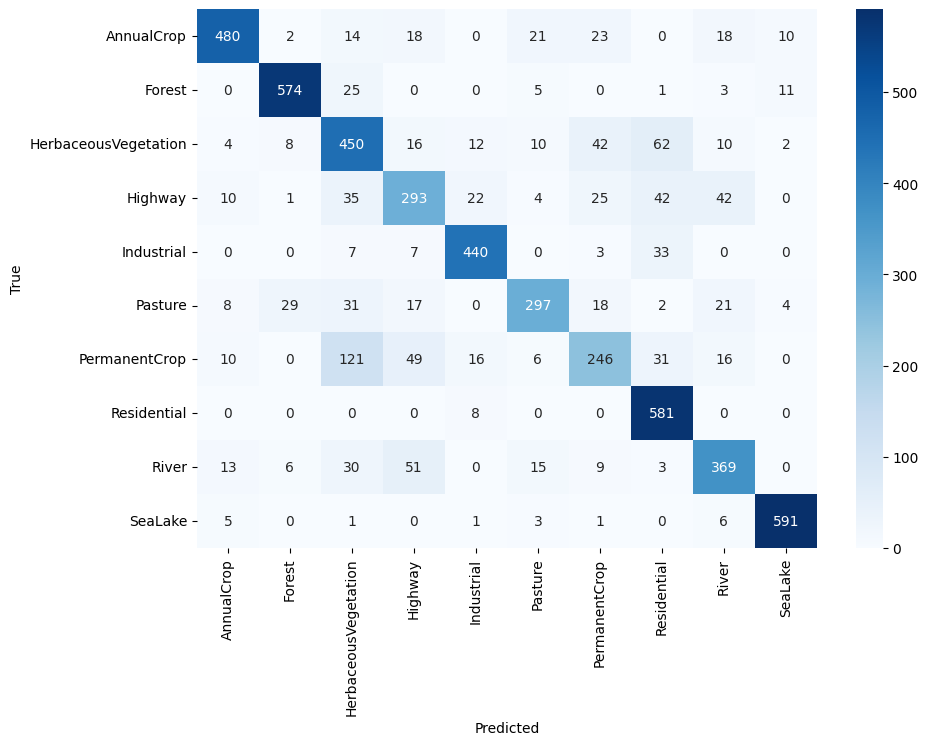

In [17]:
# Create confusion matrix with all classes
cm = confusion_matrix(all_labels, all_preds, labels=dataset.classes)

# Convert to DataFrame for better visualization
df_cm = pd.DataFrame(cm, index=dataset.classes, columns=dataset.classes)

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Notice how the model still confuses Highways with rivers and Herbaceous Vegetations with Permanent Crops.